In [1]:
%load_ext autoreload
%autoreload 2

import numpy as np
import matplotlib.pyplot as plt

from qick import *
from qick.helpers import gauss
from tqdm import tqdm_notebook as tqdm

import time
import os
import sys
sys.path.append('/home/xilinx/jupyter_notebooks/')
import scipy as sp
from scipy.fft import fft, fftfreq
import json

from slab.instruments import *
from slab.experiment import Experiment
from slab.datamanagement import SlabFile
from slab import get_next_filename, AttrDict

# Figure params
plt.rcParams['figure.figsize'] = [10,6]
plt.rcParams.update({'font.size': 14})

Could not import QickSoc: No module named 'pynq'


c:\Users\slab\anaconda3\lib\site-packages\visa.py:13: FutureWarning: The visa module provided by PyVISA is being deprecated. You can replace `import visa` by `import pyvisa as visa` to achieve the same effect.

The reason for the deprecation is the possible conflict with the visa package provided by the https://github.com/visa-sdk/visa-python which can result in hard to debug situations.
  warnings.warn(


Warning serial library import failed.


c:\Users\slab\anaconda3\lib\site-packages\IPython\qt.py:12: ShimWarning: The `IPython.qt` package has been deprecated since IPython 4.0. You should import from qtconsole instead.
  warn("The `IPython.qt` package has been deprecated since IPython 4.0. "


Could not load InstrumentManagerWindow
Could not import QickInstrument, try install qick package
Could not load AD5780 dac 
Could not load labbrick
Could not load Autonics TM4 Driver
Could not load Oxford Trition driver


# Load experiments

In [2]:
# %aimport experiments
import experiments as meas

imported experiments.clifford_averager_program
imported experiments.fitting
imported experiments.qram_protocol_timestepped
imported experiments.single_qubit.acstarkshift_spectroscopy
imported experiments.single_qubit.amplitude_rabi
imported experiments.single_qubit.length_rabi
imported experiments.single_qubit.pulse_probe_ef_spectroscopy
imported experiments.single_qubit.pulse_probe_spectroscopy
imported experiments.single_qubit.resonator_spectroscopy
imported experiments.single_qubit.rfsoc_tof_calibration
imported experiments.single_qubit.single_shot
imported experiments.single_qubit.t1
imported experiments.single_qubit.t2_echo
imported experiments.single_qubit.t2_ramsey
imported experiments.two_qubit.amplitude_rabi_EgGf
imported experiments.two_qubit.length_rabi_EgGf
imported experiments.two_qubit.pulse_probe_coupling_spectroscopy
imported experiments.two_qubit.pulse_probe_EgGf_spectroscopy
imported experiments.two_qubit.randbench
imported experiments.two_qubit.twoqutrit_state_tomogr

In [3]:
"""Reopen saved data"""
def prev_data(expt_path, filename):
    temp_data_file = expt_path+'/'+filename
    with SlabFile(temp_data_file) as a:
        attrs = dict()
        for key in list(a.attrs):
            attrs.update({key:json.loads(a.attrs[key])})
        keys = list(a)
        temp_data = dict()
        for key in keys:
            temp_data.update({key:np.array(a[key])})
        print(f'Extracted data and attrs {list(a.attrs)}')
    return temp_data, attrs

In [4]:
# expt_path=os.getcwd()+'\data_220904'
expt_path=os.getcwd()+'\data_220919'
print('Data will be stored in', expt_path)

Data will be stored in s:\Connie\experiments\qramLL_4QR2\data_220919


In [5]:
# config_file = 'config_zcu216.yml'
config_file = 'config_q3diamond.yml'
config_path = os.getcwd() + '\\' + config_file
print('Config will be', config_path)

Config will be s:\Connie\experiments\qramLL_4QR2\config_q3diamond.yml


# Setup experiment hardware

Set in config:
- LO alias, frequency, power
- SOC dac channels, nyquist zones

In [6]:
import yaml
with open(config_file, 'r') as cfg_file:
    yaml_cfg = yaml.safe_load(cfg_file)
yaml_cfg = AttrDict(yaml_cfg)

In [7]:
im = InstrumentManager()

In [ ]:
lo1 = im[yaml_cfg.aliases.readout_LO]
lo1.open_device()
print(lo1.get_id())

# # TURN OFF
# lo1.set_standby(True)
# lo1.set_output_state(False)

# TURN ON
lo1.set_standby(False)
lo1.set_output_state(True)
lo_freq = float(yaml_cfg.hw.lo.readout.frequency)
lo_power = float(yaml_cfg.hw.lo.readout.power)
lo1.set_frequency(lo_freq) # Set LO frequency
print('set freq to', lo_freq)
lo1.set_power(lo_power) # Set LO power
print('set power to', lo_power)

Default Instrument SC_26C1
set freq to 6100000000.0
set power to 10.0


In [8]:
soc = QickConfig(im[yaml_cfg['aliases']['soc']].get_cfg())
print(soc)
# print(soc.description())
# print(soc.dump_cfg())


QICK configuration:

	Board: ZCU216

	Global clocks (MHz): tProcessor 349.997, RF reference 245.760

	7 signal generator channels:
	0:	axis_sg_int4_v1 - tProc output 0, envelope memory 4096 samples
		DAC tile 2, ch 0, 16-bit DDS, fabric=430.080 MHz, fs=1720.320 MHz
	1:	axis_sg_int4_v1 - tProc output 1, envelope memory 4096 samples
		DAC tile 2, ch 1, 16-bit DDS, fabric=430.080 MHz, fs=1720.320 MHz
	2:	axis_sg_int4_v1 - tProc output 2, envelope memory 4096 samples
		DAC tile 2, ch 2, 16-bit DDS, fabric=430.080 MHz, fs=1720.320 MHz
	3:	axis_sg_int4_v1 - tProc output 3, envelope memory 4096 samples
		DAC tile 2, ch 3, 16-bit DDS, fabric=430.080 MHz, fs=1720.320 MHz
	4:	axis_signal_gen_v6 - tProc output 4, envelope memory 65536 samples
		DAC tile 3, ch 0, 32-bit DDS, fabric=599.040 MHz, fs=9584.640 MHz
	5:	axis_signal_gen_v6 - tProc output 5, envelope memory 65536 samples
		DAC tile 3, ch 1, 32-bit DDS, fabric=599.040 MHz, fs=9584.640 MHz
	6:	axis_sg_mux4_v2 - tProc output 6, envelope mem

# Run protocol

time step size [cycles]: 3


  0%|          | 0/10000 [00:00<?, ?it/s]

  0%|          | 0/10000 [00:00<?, ?it/s]

Qubit  (0)


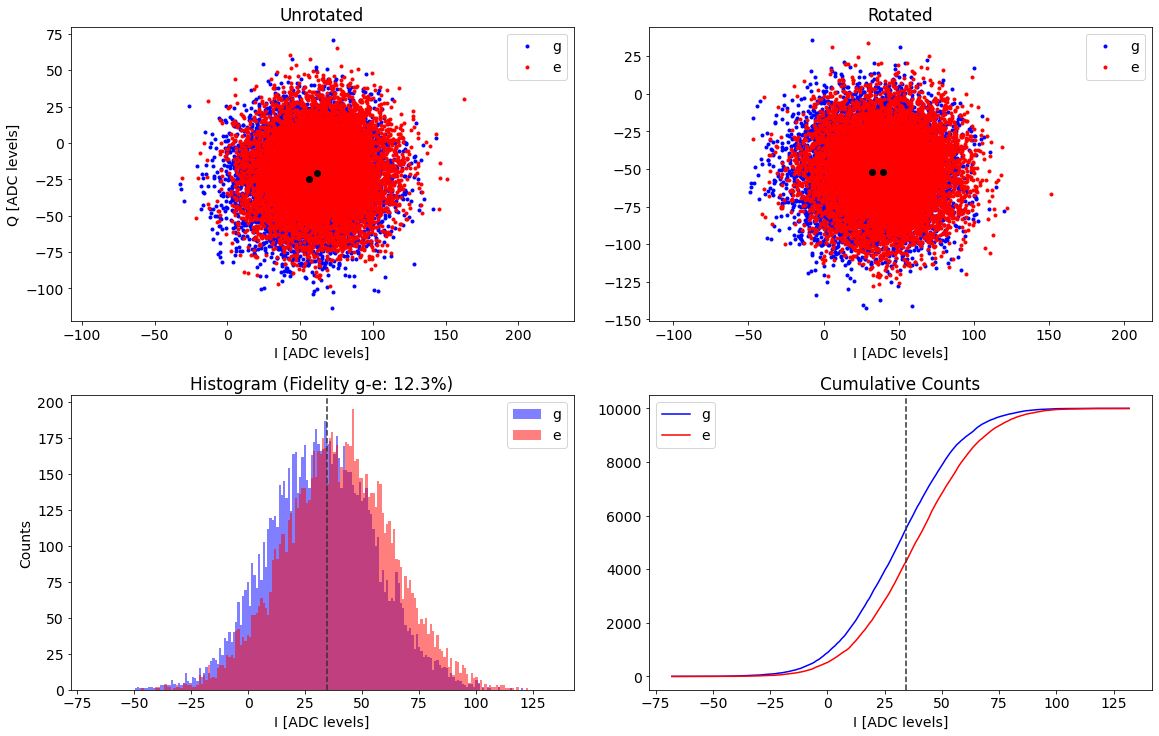

ge fidelity (%): 12.280614030701535 	 angle (deg): -34.373805838726 	 threshold ge: 34.4240002535568


  0%|          | 0/10000 [00:00<?, ?it/s]

Qubit  (1)


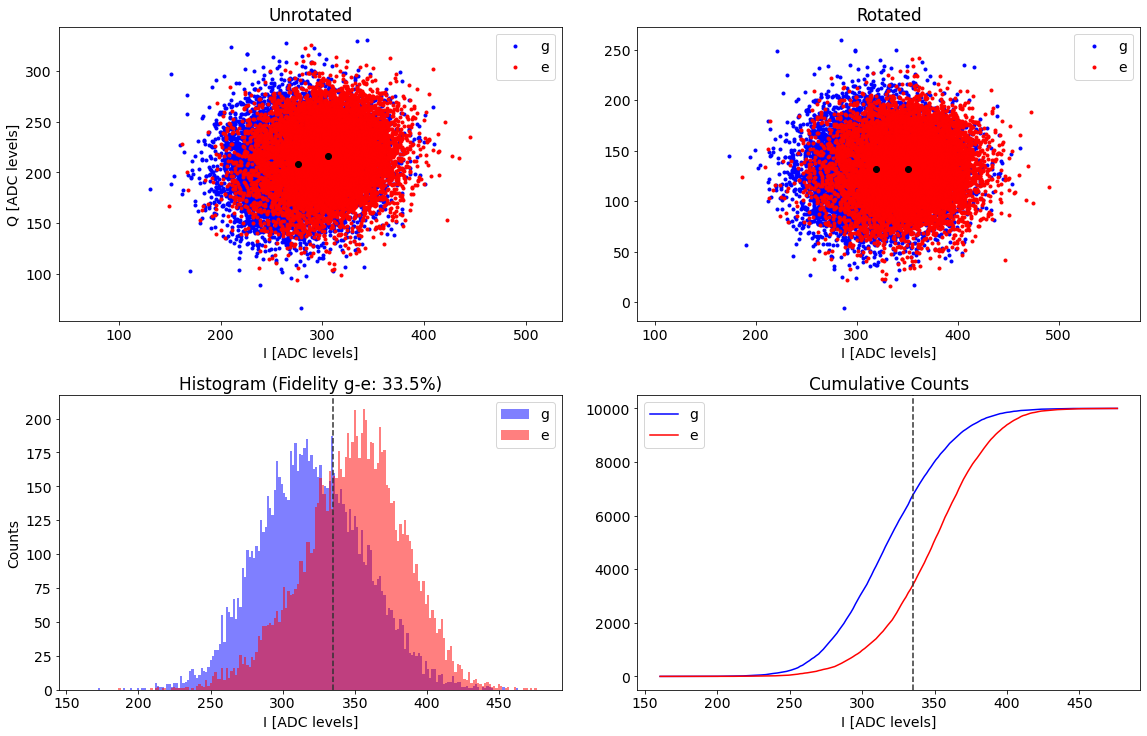

ge fidelity (%): 33.53167658382919 	 angle (deg): -14.618564662803182 	 threshold ge: 335.02063325841715


  0%|          | 0/10000 [00:00<?, ?it/s]

  0%|          | 0/10000 [00:00<?, ?it/s]

Qubit  (2)


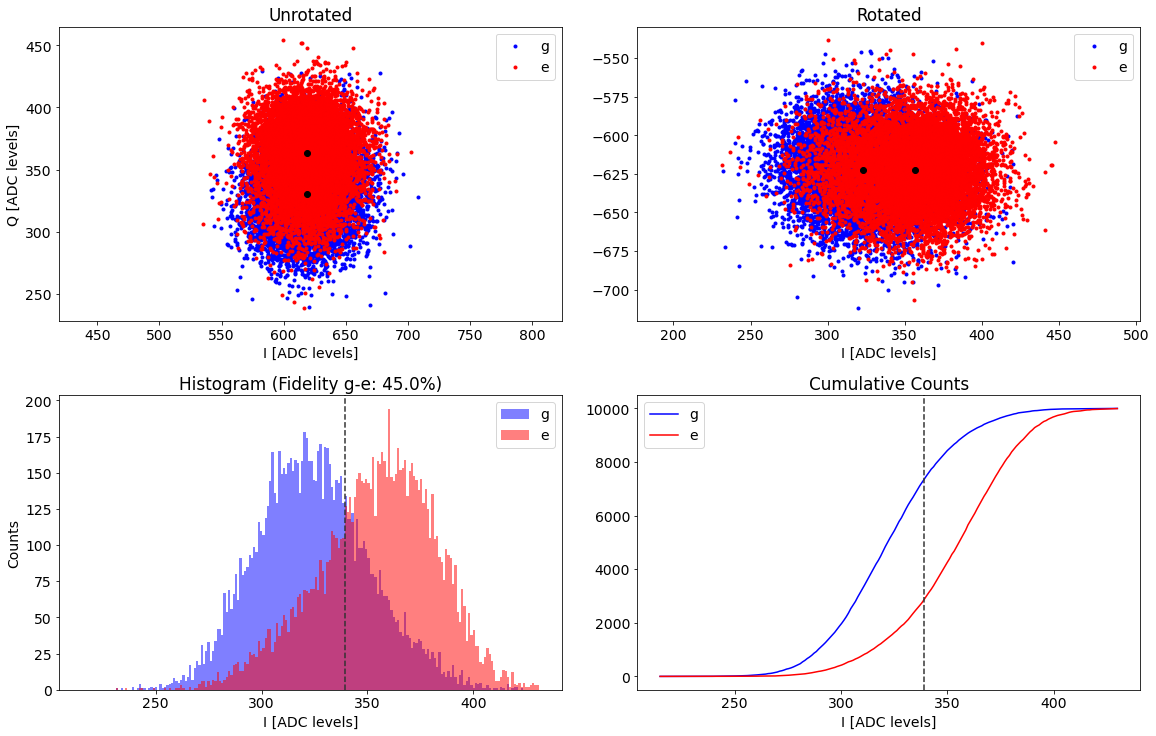

ge fidelity (%): 44.96348904671402 	 angle (deg): -90.63629078183868 	 threshold ge: 339.18940221624496


  0%|          | 0/10000 [00:00<?, ?it/s]

Qubit  (3)


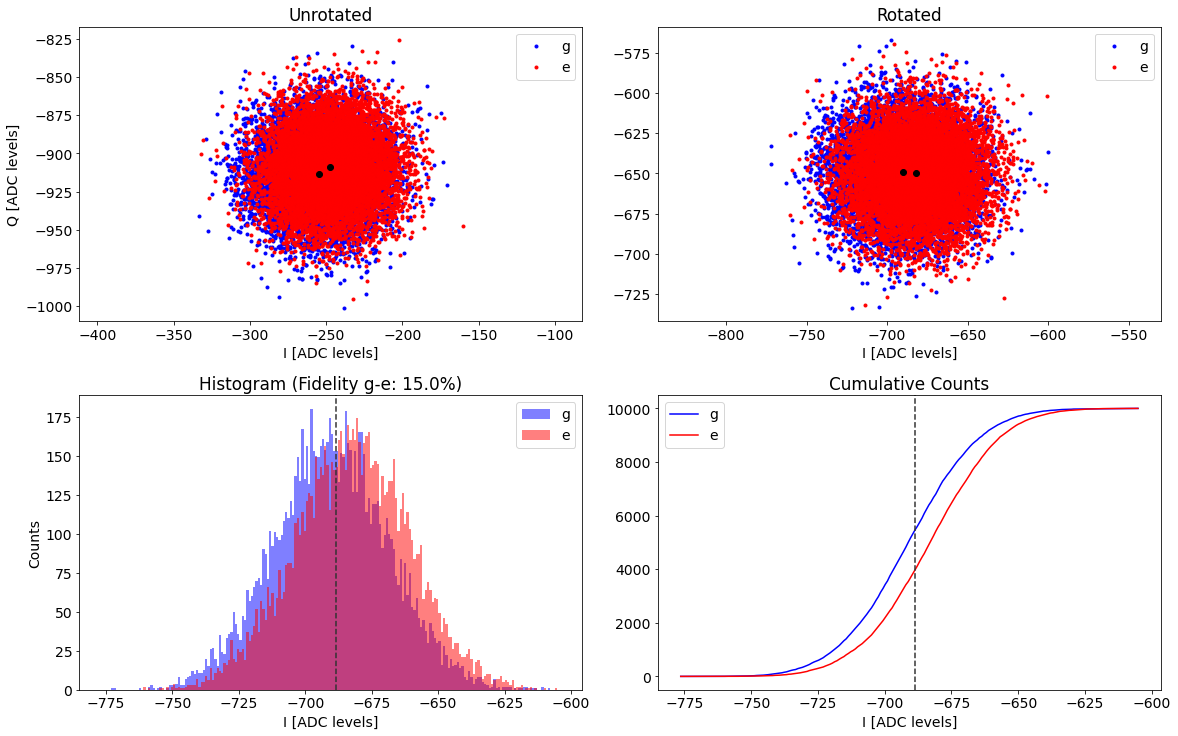

ge fidelity (%): 15.033006601320265 	 angle (deg): -31.152213248384616 	 threshold ge: -688.624538100568
thresholds=[34.4240002535568, 335.02063325841715, 339.18940221624496, -688.624538100568]
angles=[-34.373805838726, -14.618564662803182, -90.63629078183868, -31.152213248384616]
ge_avgs=[[56.03458532378783, -24.649309534656688, 61.966787243735766, -20.325632834363812], [276.91090553205333, 208.00426446469248, 304.7800947282785, 215.3356773185812], [619.0070044907256, 331.07643703221606, 618.5728837292546, 361.12236296778394], [-254.66940452326713, -912.9047285388871, -247.84987058249266, -909.0859939147413]]
dict_keys(['gg', 'eg', 'ge', 'ee'])
[32.417364651716454, 319.16690392086434, 321.78406355029085, -691.6070119836453]
[30.49162778028286, 350.9440433861622, 322.5845569425958, -691.5067192489244]
[39.57266775662839, 318.42485914012804, 321.1358178976074, -690.9197691693528]
[37.77428281085567, 351.66551841211367, 324.32015278527246, -690.5003225431192]


  0%|          | 0/200 [00:00<?, ?it/s]

Pyro traceback:
Traceback (most recent call last):
  File "<ipython-input-21-4a3a2972e185>", line 32, in <module>
    qramExpt.go(analyze=False, display=False, progress=True, save=False)
  File "C:\_Lib\python\slab\experiment.py", line 113, in go
    data=self.acquire(progress)
  File "s:\Connie\experiments\qramLL_4QR2\experiments\qram_protocol_timestepped.py", line 327, in acquire
    if self.cfg.expt.tomo_2q and time_i == len(timestep) - 1:
TypeError: object of type 'numpy.float64' has no len()



In [21]:
qramExpt = meas.QramProtocolExperiment(
    soccfg=soc,
    path=expt_path,
    config_file=config_path,
)

span = 2.0 # total time [us]
npts = 200
print('time step size [cycles]:', soc.us2cycles(span/npts))

qramExpt.cfg.expt = dict(
    start=0, # start protocol time [us],
    step=span/npts, # time step [us], 
    expts=npts, # number of different time experiments, 
    reps=5000, # number of reps per time step,
    post_process=True, # if true, uses threshold
    singleshot_reps=10000, # reps per state for singleshot calibration
    tomo_2q=True, # True/False whether to do 2q state tomography on state at last time step

    tomo_qubits=[0,1], # the qubits on which to do the 2q state tomo
    # thresholds=[23.179328085510463, 332.7232840438514, 421.8517625963923, -543.9946460140202],
    # angles=[-48.357727278342495, 179.3655091117251, 115.79976713495705, -41.070213273522114],
    # ge_avgs=[[55.440479824275954, -30.180420403514482, 60.194047608200464, -24.435568532378785], [-320.85002892938496, -124.93121298405468, -353.2516422388545, -125.4138010087862], [-697.5731328018223, -115.1149874064432, -709.8174383338757, -139.8462430198503], [101.2080142531728, -943.8882348519362, 106.53187344614383, -939.3874330296127]]
)

# qramExpt.cfg.device.readout.relax_delay = [10, 10, 10, 10] # Wait time between experiments [us]

# print(qramExpt.cfg)

import Pyro4.util
try:
    qramExpt.go(analyze=False, display=False, progress=True, save=False)
except Exception:
    print("Pyro traceback:")
    print("".join(Pyro4.util.getPyroTraceback()))

In [12]:
import numpy as np
np.where(np.array([2, 1])==2)[0][0]
calib_state = 'gg'
qi = np.where(np.array([2,1])==1)[0][0]
calib_state = calib_state[:qi] + 'e' + calib_state[qi+1:]
calib_state

'ge'

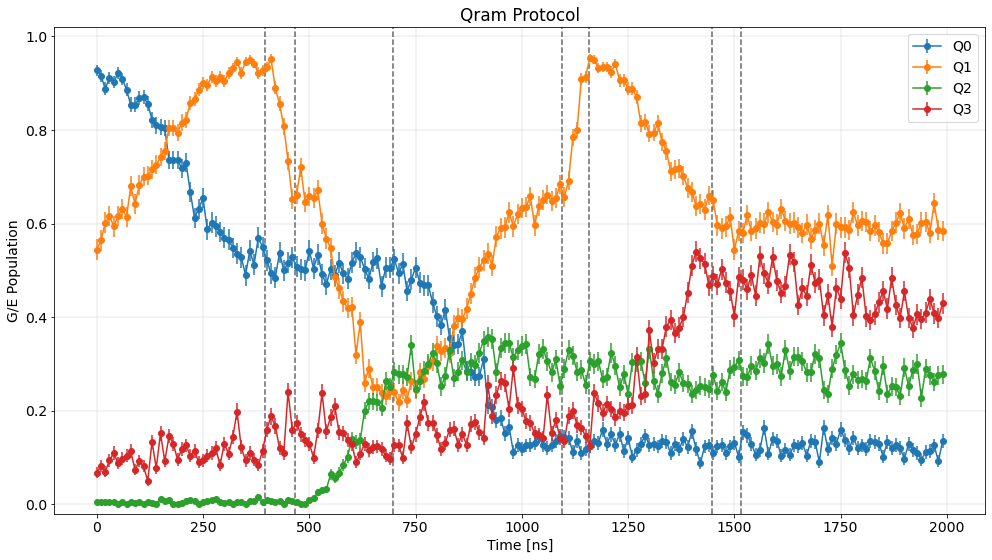

In [290]:
qramExpt.analyze()
qramExpt.display()

In [263]:
qramExpt.save_data()

Saving s:\Connie\experiments\qramLL_4QR2\data_220919\00001_qram_protocol.h5


In [265]:
x = np.array([[1,1,1], [5, 5, 5], [7,7,7]])
np.std(x,axis=1)

array([0., 0., 0.])